In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e2e-common-data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
/kaggle/input/e2e-common-data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
/kaggle/input/e2e-common-model/resnet15_electron_photon_model.pth
/kaggle/input/e2e-common-model/best_resnet15_model.pth


In [2]:
import random
import numpy as np
import torch


seed = 42
def set_seed(seed=42):
    """
    Set seed for reproducibility across numpy, torch, and random.

    Args:
        seed (int): The seed value to be set. Default is 42.
    """
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable auto-tuning for deterministic results

    print(f"Seed set to {seed}")

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import h5py
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths to the datasets
photons_path = "/kaggle/input/e2e-common-data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
electrons_path = "/kaggle/input/e2e-common-data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"

# Load the datasets
def load_data(path):
    data = []
    with h5py.File(path, 'r') as f:
        for key in f.keys():
            return f[key][:]

Seed set to 42
Using device: cuda


In [4]:
set_seed(seed)
print("Loading photon data...")
photon_data = load_data(photons_path)
print(f"Photon data shape: {photon_data.shape}")

print("Loading electron data...")
electron_data = load_data(electrons_path)
print(f"Electron data shape: {electron_data.shape}")

Seed set to 42
Loading photon data...
Photon data shape: (249000, 32, 32, 2)
Loading electron data...
Electron data shape: (249000, 32, 32, 2)


In [5]:
type(photon_data)

numpy.ndarray

In [6]:
set_seed(seed)
# Create a custom dataset class
class ParticleDataset(Dataset):
    def __init__(self, photon_data, electron_data,set_z=False,mean_std = None, transform=None):
        # Assuming data is already in shape [N, 2, 32, 32]
        # If not, reshape it
        if len(photon_data.shape) == 3:
            photon_data = photon_data.reshape(-1, 1, 32, 32)
        if len(electron_data.shape) == 3:
            electron_data = electron_data.reshape(-1, 1, 32, 32)
        self.set_z = set_z      
        self.mean_std = mean_std
        
        self.data = np.concatenate([photon_data, electron_data], axis=0)
        self.labels = np.concatenate([np.zeros(len(photon_data)), np.ones(len(electron_data))])
        
        # Shuffle the data
        indices = np.random.permutation(len(self.data))
        self.data = self.data[indices]
        self.labels = self.labels[indices]
        
        self.transform = transform
        if set_z ==1: 
            self.data,self.mean_std = self._normalize(self.data)
        else : self.data = self._normalize(self.data)
    
    def _normalize(self, data):
        # Normalize each channel independently
        if (self.set_z==0) and (self.mean_std is not None):
            print(f'using setted zs')
            for i in range(data.shape[1]):
                mean = self.mean_std['mean'][i]
                std = self.mean_std['std'][i]
                data[:, i] = (data[:, i] - mean) / (std + 1e-7)
            return data
        else :
            print(f'setting zs')
            mean_std = {'mean':np.zeros(data.shape[1]),'std':np.zeros(data.shape[1])}
            for i in range(data.shape[1]):
                mean = np.mean(data[:, i])
                mean_std['mean'][i]=mean
                std = np.std(data[:, i])
                mean_std['std'][i]=std
                data[:, i] = (data[:, i] - mean) / (std + 1e-7)
            if self.set_z==1: 
                self.mean_std = mean_std
                return data, mean_std
            return data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        
        # Convert to torch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        
        if self.transform:
            x = self.transform(x)
            
        return x, y

Seed set to 42


In [7]:
set_seed(seed)
# Check if data is already in shape [N, 2, 32, 32] or needs reshaping
print(f"Original data shapes: Photons - {photon_data.shape}, Electrons - {electron_data.shape}")

# Reshape if necessary
if len(photon_data.shape) == 3:
    photon_data = np.stack([photon_data, np.zeros_like(photon_data)], axis=1)
if len(electron_data.shape) == 3:
    electron_data = np.stack([electron_data, np.zeros_like(electron_data)], axis=1)

# If data is in shape [N, 32, 32, 2], transpose to [N, 2, 32, 32]
if photon_data.shape[-1] == 2:
    photon_data = np.transpose(photon_data, (0, 3, 1, 2))
if electron_data.shape[-1] == 2:
    electron_data = np.transpose(electron_data, (0, 3, 1, 2))

print(f"Processed data shapes: Photons - {photon_data.shape}, Electrons - {electron_data.shape}")

Seed set to 42
Original data shapes: Photons - (249000, 32, 32, 2), Electrons - (249000, 32, 32, 2)
Processed data shapes: Photons - (249000, 2, 32, 32), Electrons - (249000, 2, 32, 32)


In [8]:
set_seed(seed)
train_size = int(0.8 * len(photon_data))
photon_data_t,photon_data_v = photon_data.copy()[:train_size], photon_data.copy()[train_size:]
train_size = int(0.8 * len(electron_data))
electron_data_t,electron_data_v = electron_data.copy()[:train_size], electron_data.copy()[train_size:]
print(f'photon:{photon_data_t.shape}, {photon_data_v.shape}')
print(f'electron:{electron_data_t.shape}, {electron_data_v.shape}')

Seed set to 42
photon:(199200, 2, 32, 32), (49800, 2, 32, 32)
electron:(199200, 2, 32, 32), (49800, 2, 32, 32)


In [9]:
set_seed(seed)
# Create the dataset
train_dataset = ParticleDataset(photon_data_t, electron_data_t,set_z=1)
test_dataset = ParticleDataset(photon_data_v, electron_data_v,set_z=0,mean_std = train_dataset.mean_std)

# Split the dataset into training and test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Seed set to 42
setting zs
using setted zs
Training set size: 398400
Test set size: 99600


Seed set to 42


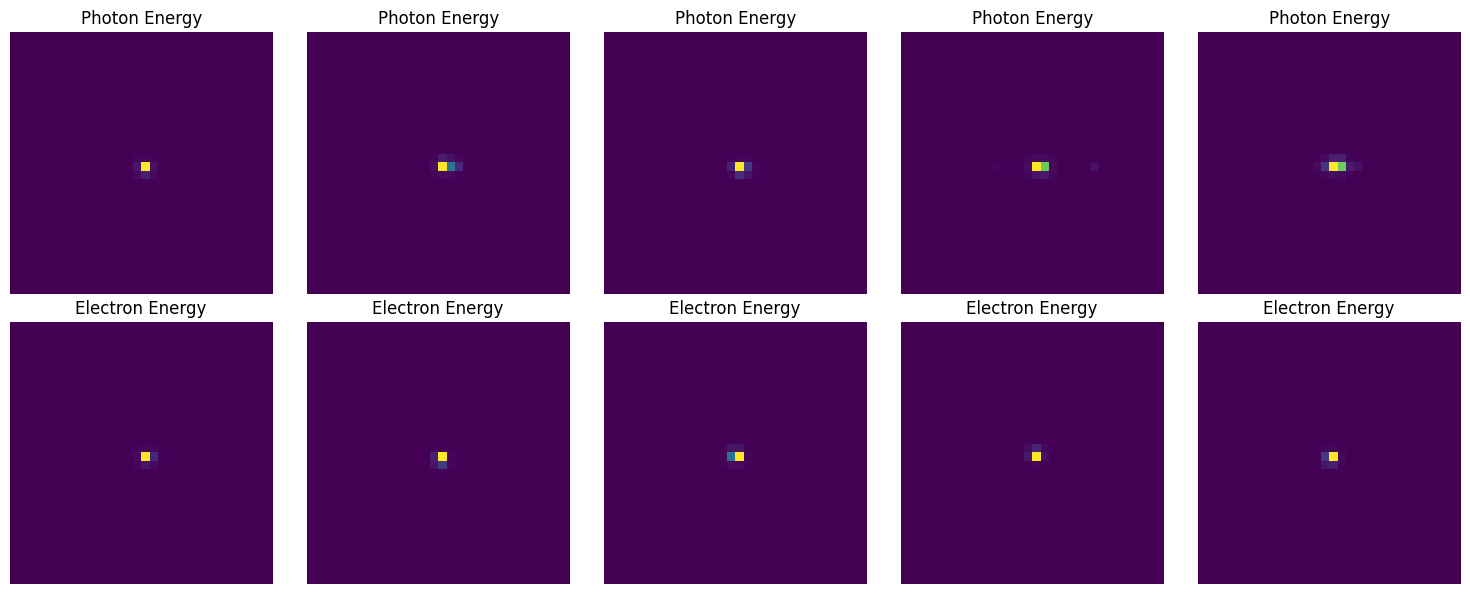

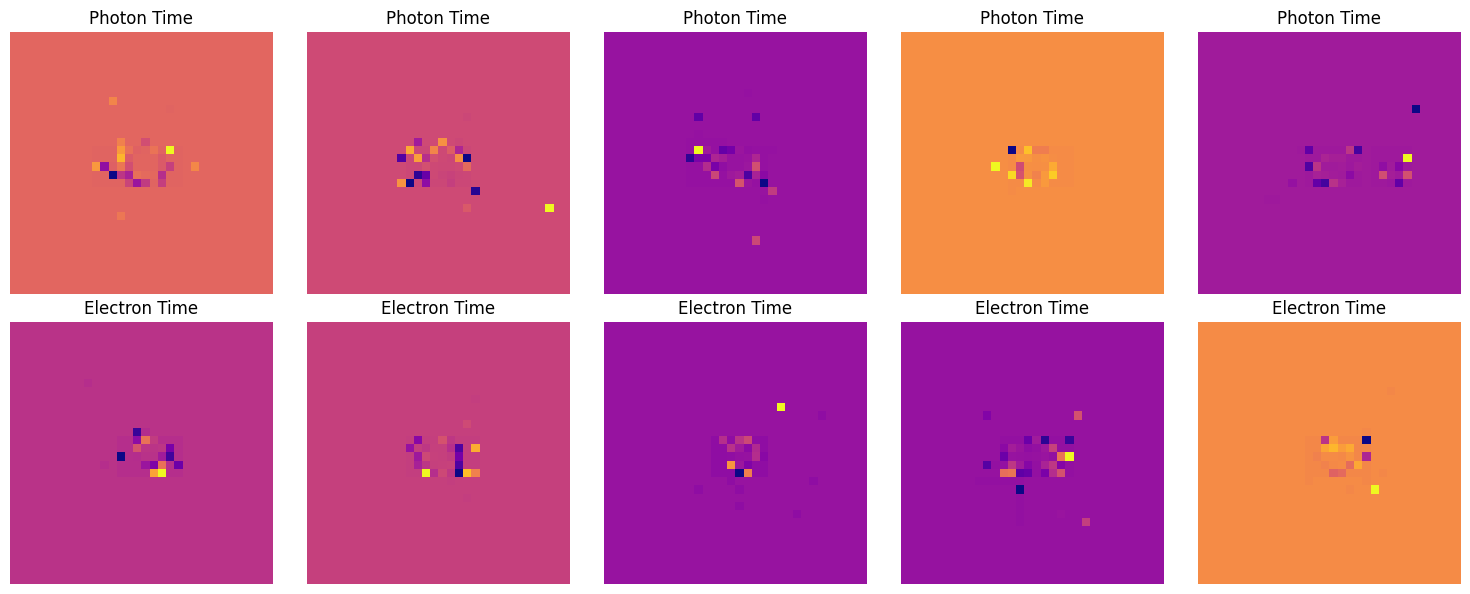

In [10]:
set_seed(seed)
# Visualize some samples
sample_idxs = []
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Get a photon sample (label 0)
        photon_indices = np.where(dataset.labels == 0)[0]
        photon_idx = np.random.choice(photon_indices)
        sample_idxs.append(photon_idx)
        photon_sample, _ = dataset[photon_idx]
        
        # Get an electron sample (label 1)
        electron_indices = np.where(dataset.labels == 1)[0]
        electron_idx = np.random.choice(electron_indices)
        sample_idxs.append(electron_idx)
        electron_sample, _ = dataset[electron_idx]
        
        # Display channel 0 (energy)
        axes[0, i].imshow(photon_sample[0].numpy(), cmap='viridis')
        axes[0, i].set_title(f"Photon Energy")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(electron_sample[0].numpy(), cmap='viridis')
        axes[1, i].set_title(f"Electron Energy")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Now show channel 1 (time) if available
    if photon_sample.shape[0] > 1:
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        
        for i in range(num_samples):
            photon_indices = np.where(dataset.labels == 0)[0]
            photon_idx = np.random.choice(photon_indices)
            photon_sample, _ = dataset[photon_idx]
            
            electron_indices = np.where(dataset.labels == 1)[0]
            electron_idx = np.random.choice(electron_indices)
            electron_sample, _ = dataset[electron_idx]
            
            # Display channel 1 (time)
            axes[0, i].imshow(photon_sample[1].numpy(), cmap='plasma')
            axes[0, i].set_title(f"Photon Time")
            axes[0, i].axis('off')
            
            axes[1, i].imshow(electron_sample[1].numpy(), cmap='plasma')
            axes[1, i].set_title(f"Electron Time")
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Uncomment to visualize samples
visualize_samples(test_dataset)

In [11]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (input_size // 8) * (input_size // 8), 64)  # Adjust based on input size
        self.fc2 = nn.Linear(64, 2)  # Two classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation, CrossEntropyLoss expects raw logits
        return x

# Example usage
# input_size = 64  # Example image size (64x64)
# model = CNNModel()
# print(model)

In [13]:
# Define training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Define evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Save predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Get probabilities for ROC curve
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

In [14]:
set_seed(seed)
# Create the ResNet-15 model
# Using configuration [2, 2, 2] for 15 total layers:
# 1 (conv1) + 2*2 (layer1) + 2*2 (layer2) + 2*2 (layer3) + 1 (fc) = 15
# model = ResNet15(BasicBlock, [2, 2, 2], num_classes=2, in_channels=photon_data.shape[1])
input_size = 32
model = CNNModel()
model = model.to(device)
# model.load_state_dict(torch.load('best_cnn_model.pth'))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model
num_epochs = 5
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    torch.cuda.empty_cache()
    # Train
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    val_loss, val_acc, _, _, _ = evaluate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    # scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
    
    print(f"Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

Seed set to 42

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/6225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1557 [00:00<?, ?it/s]

Training Loss: 0.6038, Training Acc: 0.6795
Validation Loss: 0.5744, Validation Acc: 0.7118

Epoch 2/5


Training:   0%|          | 0/6225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1557 [00:00<?, ?it/s]

Training Loss: 0.5642, Training Acc: 0.7171
Validation Loss: 0.5572, Validation Acc: 0.7215

Epoch 3/5


Training:   0%|          | 0/6225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1557 [00:00<?, ?it/s]

Training Loss: 0.5535, Training Acc: 0.7246
Validation Loss: 0.5492, Validation Acc: 0.7280

Epoch 4/5


Training:   0%|          | 0/6225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1557 [00:00<?, ?it/s]

Training Loss: 0.5474, Training Acc: 0.7286
Validation Loss: 0.5511, Validation Acc: 0.7245

Epoch 5/5


Training:   0%|          | 0/6225 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1557 [00:00<?, ?it/s]

Training Loss: 0.5441, Training Acc: 0.7311
Validation Loss: 0.5418, Validation Acc: 0.7327


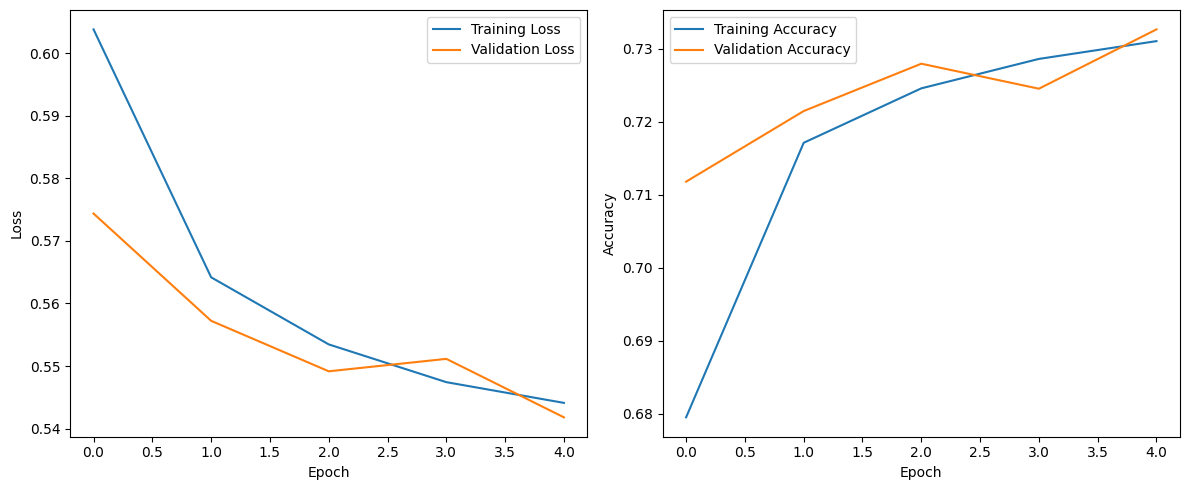

In [15]:
# Plot training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-16-ef6e184be3df>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))


Evaluating:   0%|          | 0/1557 [00:00<?, ?it/s]


Test Loss: 0.5418, Test Accuracy: 0.7327


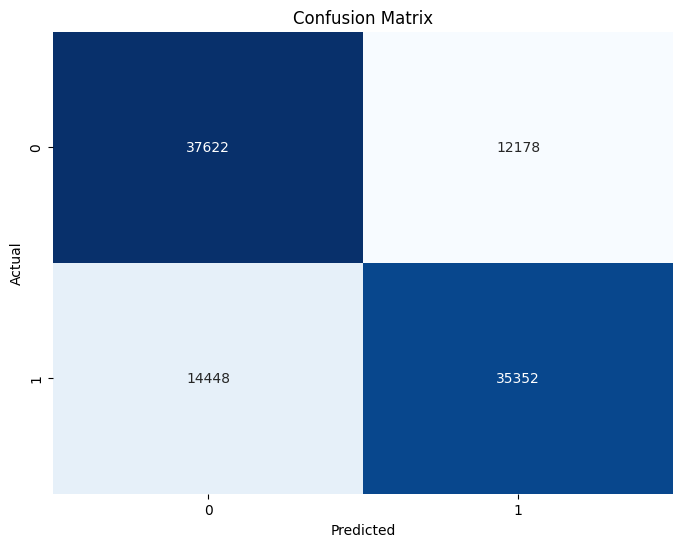


Classification Report:
              precision    recall  f1-score   support

      Photon       0.72      0.76      0.74     49800
    Electron       0.74      0.71      0.73     49800

    accuracy                           0.73     99600
   macro avg       0.73      0.73      0.73     99600
weighted avg       0.73      0.73      0.73     99600



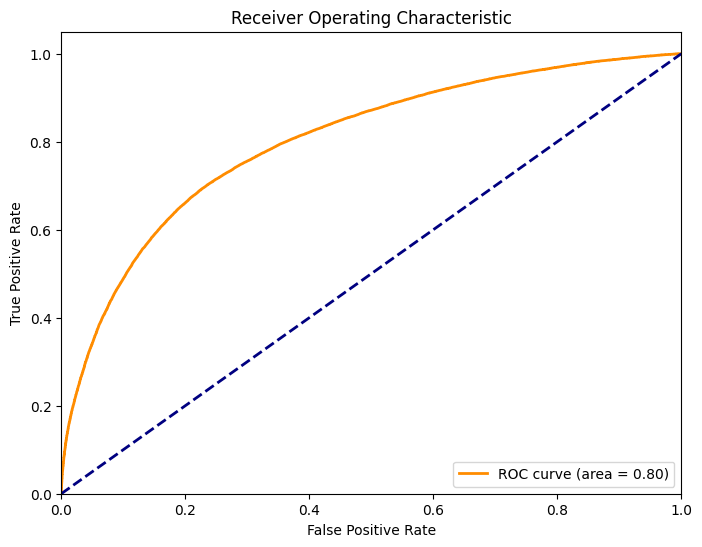

In [16]:
# Load the best model
yes = 1
if yes:
    model.load_state_dict(torch.load('best_cnn_model.pth'))
else:
    model.load_state_dict(torch.load('/kaggle/input/e2e-common-model/best_resnet18_model.pth'))

# Evaluate the model on the test set
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=['Photon', 'Electron'])
print("\nClassification Report:")
print(report)

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Seed set to 42


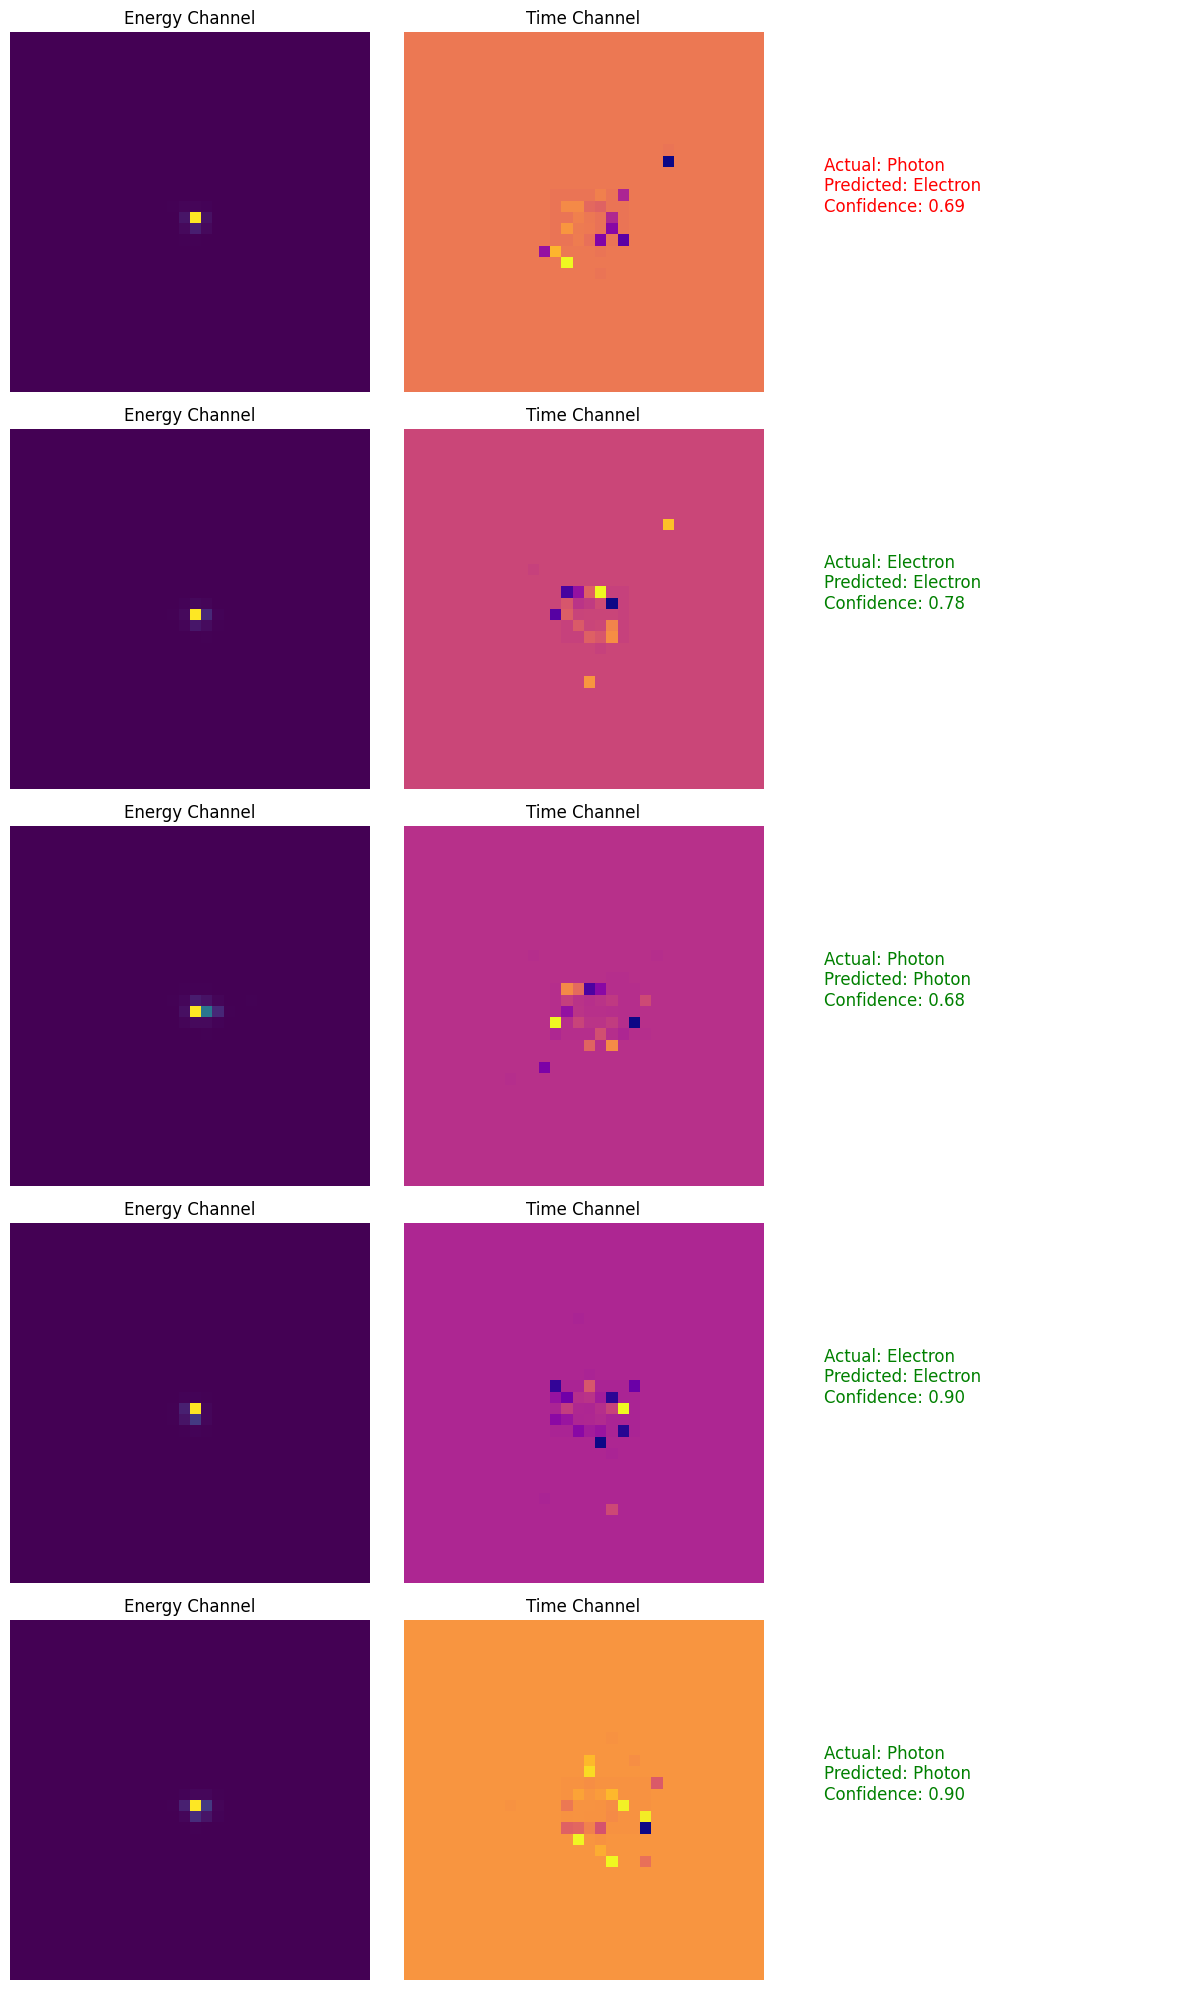

In [17]:
set_seed(seed)
# Visualize model predictions
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    with torch.no_grad():
        sample_count = 0
        for idx in sample_idxs:
            if sample_count >= num_samples:
                break
            inputs, labels = dataset[idx]
            inputs,labels = inputs.unsqueeze(0),labels.unsqueeze(0)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            input_img = inputs[0].cpu().numpy()
            actual = labels[0].item()
            pred = predicted[0].item()
            prob = probs[0][pred].item()
            
            # Display energy channel
            axes[sample_count, 0].imshow(input_img[0], cmap='viridis')
            axes[sample_count, 0].set_title(f"Energy Channel")
            axes[sample_count, 0].axis('off')
            
            # Display time channel if available
            if input_img.shape[0] > 1:
                axes[sample_count, 1].imshow(input_img[1], cmap='plasma')
                axes[sample_count, 1].set_title(f"Time Channel")
                axes[sample_count, 1].axis('off')
            else:
                axes[sample_count, 1].axis('off')
            
            # Display prediction info
            axes[sample_count, 2].axis('off')
            color = 'green' if pred == actual else 'red'
            actual_label = 'Photon' if actual == 0 else 'Electron'
            pred_label = 'Photon' if pred == 0 else 'Electron'
            axes[sample_count, 2].text(0.1, 0.5, 
                                    f"Actual: {actual_label}\nPredicted: {pred_label}\nConfidence: {prob:.2f}",
                                    fontsize=12, color=color)
            
            sample_count += 1
    
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
visualize_predictions(model, test_dataset, device)

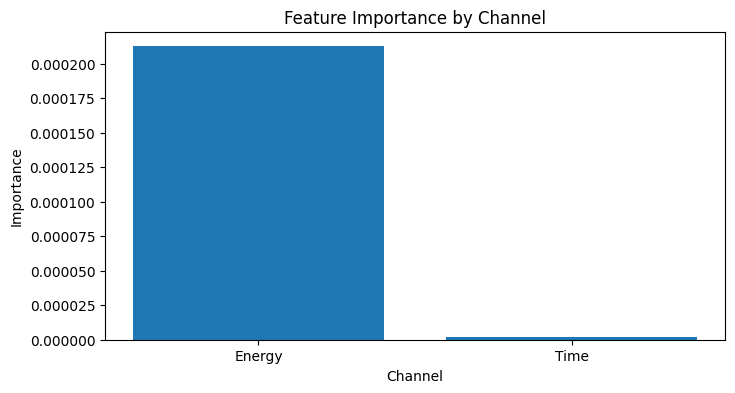

In [18]:
# Feature Importance Visualization using Gradient-based methods
def compute_feature_importance(model, test_loader, device):
    model.eval()
    
    # Get a batch of data
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    inputs.requires_grad = True
    
    # Forward pass
    outputs = model(inputs)
    
    # Compute gradients for the true class
    model.zero_grad()
    outputs[0, labels[0]].backward()
    
    # Get the gradients
    gradients = inputs.grad.cpu().numpy()
    
    # Compute the mean absolute gradients for each channel
    importance = np.abs(gradients).mean(axis=0).mean(axis=1).mean(axis=1)
    
    return importance

# Compute feature importance
importance = compute_feature_importance(model, test_loader, device)

# Plot feature importance
plt.figure(figsize=(8, 4))
plt.bar(range(len(importance)), importance)
plt.xlabel('Channel')
plt.ylabel('Importance')
plt.title('Feature Importance by Channel')
plt.xticks(range(len(importance)), ['Energy', 'Time'] if len(importance) > 1 else ['Energy'])
plt.show()

In [19]:
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
    'test_acc': test_acc,
    'test_loss': test_loss,
}, 'resnet15_electron_photon_model.pth')

print("Final model saved as 'cnn_model.pth'")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Final model saved as 'cnn_model.pth'
Best validation accuracy: 0.7327
Test accuracy: 0.7327


In [20]:
# Function to make predictions on new data
def predict(model, data_path, device):
    model.eval()
    
    # Load and preprocess the data
    data = load_data(data_path)
    
    # Reshape if necessary
    if len(data.shape) == 3:
        data = np.stack([data, np.zeros_like(data)], axis=1)
    if data.shape[-1] == 2:
        data = np.transpose(data, (0, 3, 1, 2))
    
    # Normalize
    for i in range(data.shape[1]):
        mean = np.mean(data[:, i])
        std = np.std(data[:, i])
        data[:, i] = (data[:, i] - mean) / (std + 1e-7)
    
    # Convert to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(data_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
    
    return predicted.cpu().numpy(), probs.cpu().numpy()

# Example of how to use the prediction function
# predictions, probabilities = predict(model, "path_to_new_data", device)